In [17]:
# Setup and imports
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set project root
project_root = Path("/home/Plutonium/Documents/BioinfoMidterm")
os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML imports
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Part 2 imports
from part2.ml_comparison import (
    get_default_classifiers,
    prepare_data,
    run_model_comparison,
    generate_confusion_matrices,
    plot_confusion_matrices,
    plot_performance_comparison,
    create_summary_report
)

# Project imports
import config as cfg
cfg.set_population_config("sea_jpt_cn")

PATHS = cfg.PATHS

print("All imports successful!")

Working directory: /home/Plutonium/Documents/BioinfoMidterm
All imports successful!


## Step 1: Load ML Matrices

In [18]:
# Paths - Use sea_jpt_cn specific directories
PART2_DIR = project_root / "output" / "part2" / "sea_jpt_cn"
GRAPHS_DIR = project_root / "graphs" / "part2" / "sea_jpt_cn"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

# Find all ML matrix files
ml_files = list(PART2_DIR.glob("*_ml_matrix.csv"))

# Also include statistical SNPs from Part 1 (sea_jpt_cn output)
stat_path = PATHS.OUTPUT_DIR / "statistical_ml_data_02b.csv"

print(f"Found {len(ml_files)} ML matrices in Part 2 (sea_jpt_cn):")
for f in ml_files:
    print(f"  - {f.name}")

if stat_path.exists():
    print(f"\nAlso including: {stat_path}")

Found 5 ML matrices in Part 2 (sea_jpt_cn):
  - cal_et_al_ml_matrix.csv
  - seldin_128_ml_matrix.csv
  - forenseq_ml_matrix.csv
  - kidd_55_ml_matrix.csv
  - hsiao_lin_hwa_ml_matrix.csv

Also including: 1000genomes/output_sea_jpt_cn/statistical_ml_data_02b.csv


In [19]:
# Load all matrices
datasets = {}

for ml_file in ml_files:
    name = ml_file.stem.replace('_ml_matrix', '')
    df = pd.read_csv(ml_file)
    datasets[name] = df
    print(f"Loaded {name}: {df.shape}")

# Add statistical SNPs
if stat_path.exists():
    stat_df = pd.read_csv(stat_path)
    datasets['statistical_all4'] = stat_df
    print(f"Loaded statistical_all4: {stat_df.shape}")

print(f"\nTotal datasets: {len(datasets)}")

Loaded cal_et_al: (504, 54)
Loaded seldin_128: (504, 126)
Loaded forenseq: (504, 57)
Loaded kidd_55: (504, 55)
Loaded hsiao_lin_hwa: (504, 127)
Loaded statistical_all4: (504, 33)

Total datasets: 6


## Step 2: Dataset Overview

In [20]:
# Create overview table
overview = []

for name, df in datasets.items():
    snp_cols = [c for c in df.columns if c not in ['sample', 'pop', 'source']]
    overview.append({
        'Source': name,
        'Samples': len(df),
        'SNPs': len(snp_cols),
        'Populations': df['pop'].nunique(),
        'Pop_List': ', '.join(df['pop'].unique())
    })

overview_df = pd.DataFrame(overview)
print("DATASET OVERVIEW")
print("="*80)
display(overview_df)

DATASET OVERVIEW


,Source,Samples,SNPs,Populations,Pop_List
0,cal_et_al,504,52,3,"CN, SEA, JPT"
1,seldin_128,504,124,3,"CN, SEA, JPT"
2,forenseq,504,55,3,"CN, SEA, JPT"
3,kidd_55,504,53,3,"CN, SEA, JPT"
4,hsiao_lin_hwa,504,125,3,"CN, SEA, JPT"
5,statistical_all4,504,31,3,"CN, SEA, JPT"


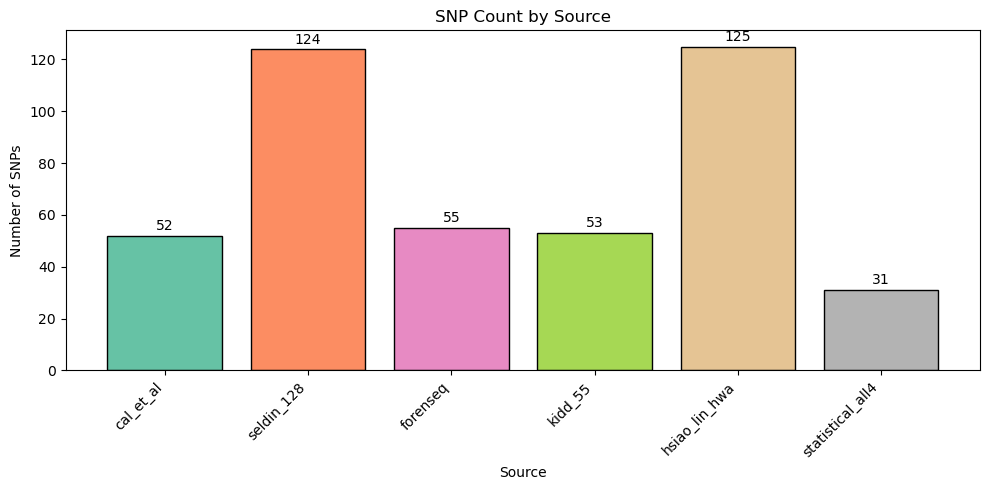

In [21]:
# Visualization: SNP counts
fig, ax = plt.subplots(figsize=(10, 5))

colors = plt.cm.Set2(np.linspace(0, 1, len(overview_df)))
bars = ax.bar(overview_df['Source'], overview_df['SNPs'], color=colors, edgecolor='black')

ax.set_xlabel('Source')
ax.set_ylabel('Number of SNPs')
ax.set_title('SNP Count by Source')
ax.set_xticklabels(overview_df['Source'], rotation=45, ha='right')

# Add count labels on bars
for bar, count in zip(bars, overview_df['SNPs']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'snp_counts_by_source.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 3: Define Classifiers

In [22]:
# Define classifiers for comparison
classifiers = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1,
        random_state=42, n_jobs=-1, verbosity=0
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, multi_class='multinomial', n_jobs=-1
    ),
    'SVM (RBF)': SVC(
        kernel='rbf', random_state=42, probability=True
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5, n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=5, random_state=42
    ),
    'MLP Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True
    )
}

print(f"Classifiers: {len(classifiers)}")
for name in classifiers.keys():
    print(f"  - {name}")

Classifiers: 7
  - Random Forest
  - XGBoost
  - Logistic Regression
  - SVM (RBF)
  - K-Nearest Neighbors
  - Gradient Boosting
  - MLP Neural Network


## Step 4: K-Fold Cross-Validation on All Sources

In [23]:
# Run K-fold CV on all datasets
N_FOLDS = 5

all_results = []

for source_name, df in datasets.items():
    results = run_model_comparison(
        df=df,
        classifiers=classifiers,
        n_folds=N_FOLDS,
        source_name=source_name
    )
    all_results.append(results)

# Combine all results
results_df = pd.concat(all_results, ignore_index=True)

print(f"\n\n{'='*70}")
print("ALL RESULTS")
print(f"{'='*70}")
display(results_df)


Running 5-Fold CV on cal_et_al
Samples: 504, SNPs: 52, Classes: ['CN', 'JPT', 'SEA']
  Random Forest: Acc=0.8948±0.0259, F1=0.8945
  XGBoost: Acc=0.8928±0.0412, F1=0.8922
  Logistic Regression: Acc=0.9028±0.0275, F1=0.9027
  SVM (RBF): Acc=0.9107±0.0229, F1=0.9107
  K-Nearest Neighbors: Acc=0.8313±0.0168, F1=0.8251
  Gradient Boosting: Acc=0.8947±0.0422, F1=0.8944
  MLP Neural Network: Acc=0.8790±0.0334, F1=0.8787

Running 5-Fold CV on seldin_128
Samples: 504, SNPs: 124, Classes: ['CN', 'JPT', 'SEA']
  Random Forest: Acc=0.5634±0.0322, F1=0.5153
  XGBoost: Acc=0.6052±0.0382, F1=0.5964
  Logistic Regression: Acc=0.6388±0.0278, F1=0.6369
  SVM (RBF): Acc=0.6488±0.0432, F1=0.6226
  K-Nearest Neighbors: Acc=0.4782±0.0131, F1=0.4584
  Gradient Boosting: Acc=0.5754±0.0214, F1=0.5667
  MLP Neural Network: Acc=0.6368±0.0569, F1=0.6300

Running 5-Fold CV on forenseq
Samples: 504, SNPs: 55, Classes: ['CN', 'JPT', 'SEA']
  Random Forest: Acc=0.6249±0.0559, F1=0.6048
  XGBoost: Acc=0.6448±0.0532,

,Source,N_SNPs,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Recall_Mean,Train_Accuracy,Overfit_Gap
0,cal_et_al,52,Random Forest,0.894772,0.025882,0.894500,0.025673,0.899137,0.894772,0.997022,0.102250
1,cal_et_al,52,XGBoost,0.892752,0.041178,0.892194,0.041590,0.897580,0.892752,1.000000,0.107248
2,cal_et_al,52,Logistic Regression,0.902792,0.027532,0.902688,0.027224,0.904601,0.902792,0.988094,0.085302
3,cal_et_al,52,SVM (RBF),0.910653,0.022893,0.910662,0.022636,0.913895,0.910653,0.982140,0.071487
4,cal_et_al,52,K-Nearest Neighbors,0.831327,0.016794,0.825070,0.015707,0.859677,0.831327,0.898797,0.067471
5,cal_et_al,52,Gradient Boosting,0.894733,0.042227,0.894379,0.042390,0.899260,0.894733,1.000000,0.105267
6,cal_et_al,52,MLP Neural Network,0.878950,0.033436,0.878746,0.033561,0.882981,0.878950,0.928572,0.049621
7,seldin_128,124,Random Forest,0.563426,0.032234,0.515331,0.036801,0.512244,0.563426,1.000000,0.436574
8,seldin_128,124,XGBoost,0.605168,0.038166,0.596435,0.039520,0.609472,0.605168,1.000000,0.394832
9,seldin_128,124,Logistic Regression,0.638832,0.027776,0.636938,0.027127,0.639396,0.638832,0.990573,0.351741


## Step 5: Performance Comparison Visualization

In [24]:
# Pivot table: Models as rows, Sources as columns
pivot_accuracy = results_df.pivot(index='Model', columns='Source', values='Accuracy_Mean')
pivot_f1 = results_df.pivot(index='Model', columns='Source', values='F1_Mean')

print("Accuracy by Model and Source:")
display(pivot_accuracy.round(4))

print("\nF1 Score by Model and Source:")
display(pivot_f1.round(4))

Accuracy by Model and Source:


Source,cal_et_al,forenseq,hsiao_lin_hwa,kidd_55,seldin_128,statistical_all4
Model,,,,,,
Gradient Boosting,0.8947,0.6012,0.5357,0.5991,0.5754,0.8035
K-Nearest Neighbors,0.8313,0.5140,0.4445,0.5398,0.4782,0.7003
Logistic Regression,0.9028,0.6726,0.5595,0.6726,0.6388,0.8471
MLP Neural Network,0.8790,0.5591,0.5319,0.5373,0.6368,0.8095
Random Forest,0.8948,0.6249,0.5575,0.6131,0.5634,0.8273
SVM (RBF),0.9107,0.6408,0.6269,0.6488,0.6488,0.8293
XGBoost,0.8928,0.6448,0.5634,0.6369,0.6052,0.8452



F1 Score by Model and Source:


Source,cal_et_al,forenseq,hsiao_lin_hwa,kidd_55,seldin_128,statistical_all4
Model,,,,,,
Gradient Boosting,0.8944,0.5977,0.5252,0.5946,0.5667,0.8044
K-Nearest Neighbors,0.8251,0.5059,0.4150,0.5319,0.4584,0.7039
Logistic Regression,0.9027,0.6710,0.5587,0.6718,0.6369,0.8477
MLP Neural Network,0.8787,0.5533,0.5214,0.5222,0.6300,0.8088
Random Forest,0.8945,0.6048,0.5200,0.5944,0.5153,0.8281
SVM (RBF),0.9107,0.6309,0.6020,0.6410,0.6226,0.8306
XGBoost,0.8922,0.6407,0.5550,0.6322,0.5964,0.8458


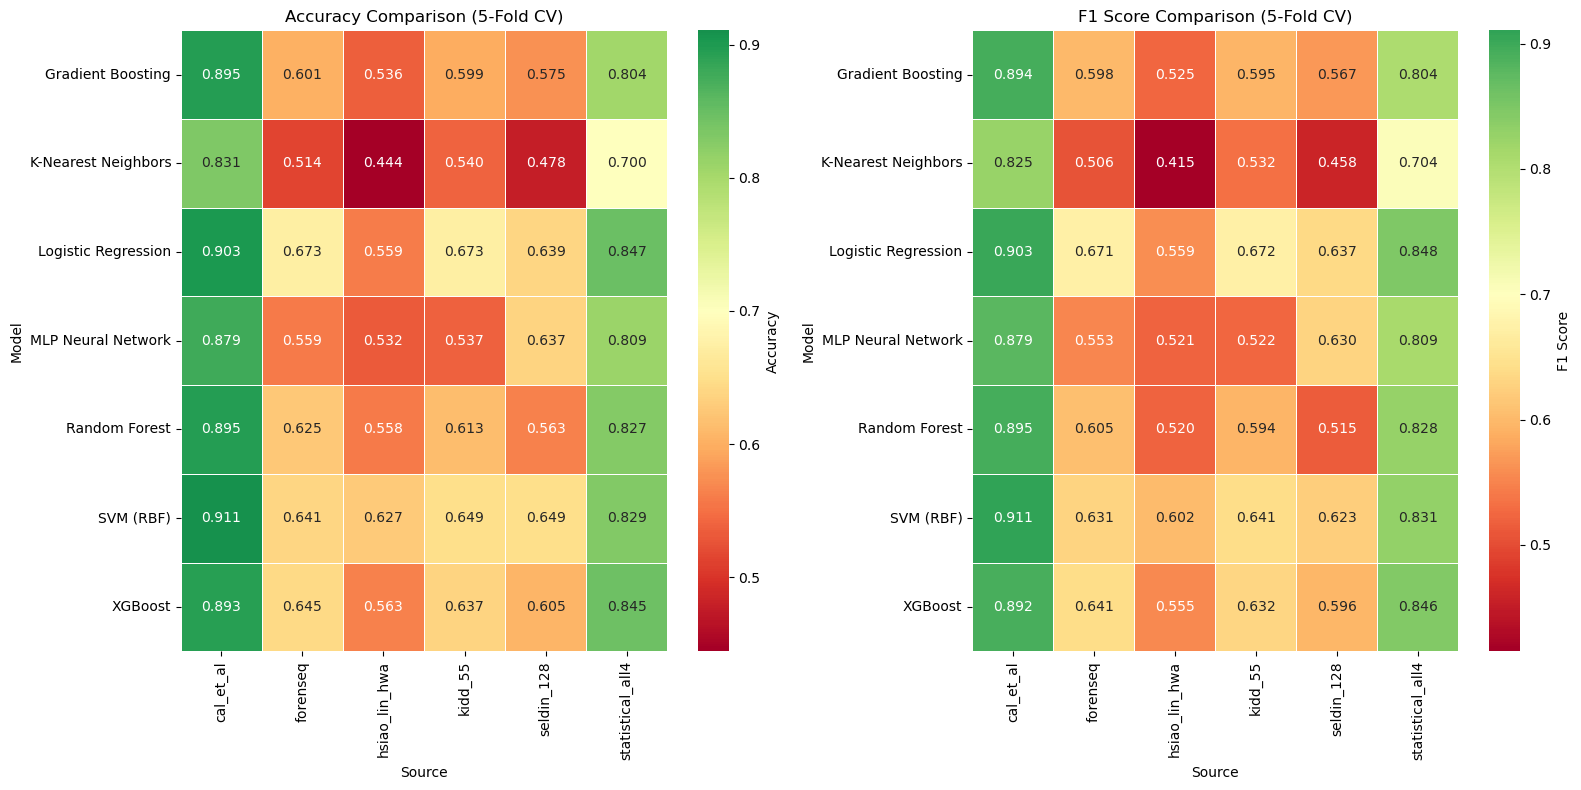

In [25]:
# Heatmap: Accuracy
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Accuracy heatmap
ax = axes[0]
sns.heatmap(pivot_accuracy, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0.7, linewidths=0.5, ax=ax,
            cbar_kws={'label': 'Accuracy'})
ax.set_title(f'Accuracy Comparison ({N_FOLDS}-Fold CV)')
ax.set_xlabel('Source')
ax.set_ylabel('Model')

# F1 heatmap
ax = axes[1]
sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0.7, linewidths=0.5, ax=ax,
            cbar_kws={'label': 'F1 Score'})
ax.set_title(f'F1 Score Comparison ({N_FOLDS}-Fold CV)')
ax.set_xlabel('Source')
ax.set_ylabel('Model')

plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'performance_heatmaps.png'), dpi=150, bbox_inches='tight')
plt.show()

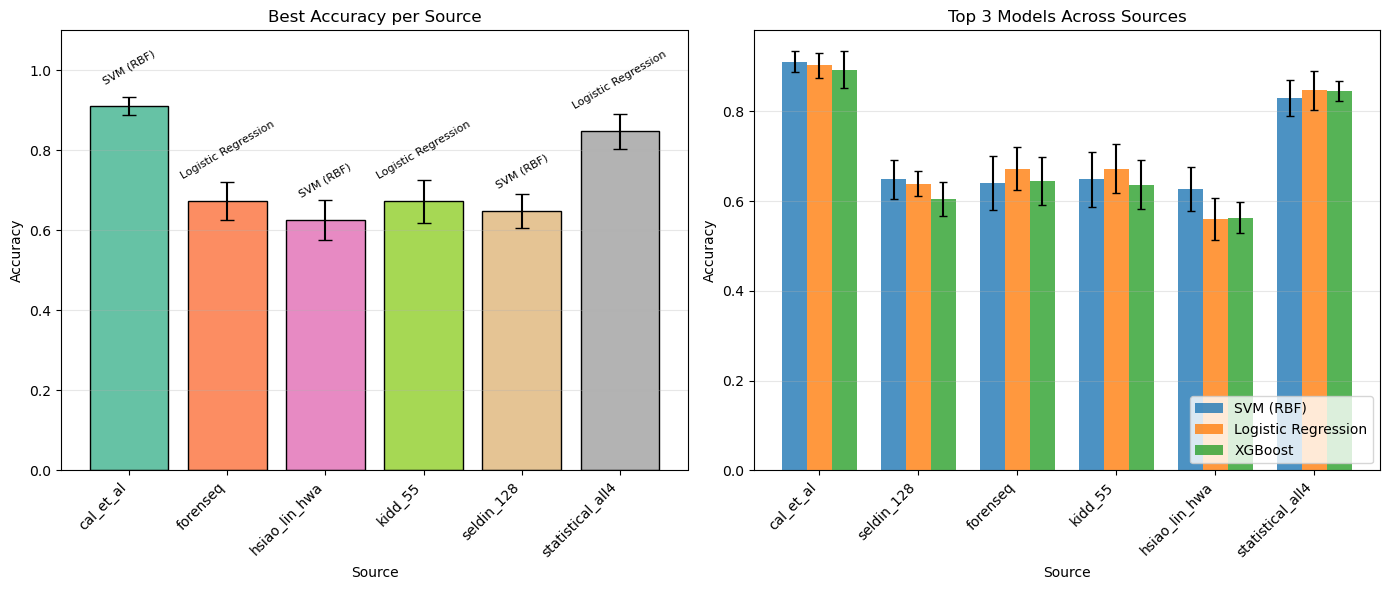

In [26]:
# Bar chart: Best model per source
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Best accuracy per source
ax = axes[0]
best_per_source = results_df.loc[results_df.groupby('Source')['Accuracy_Mean'].idxmax()]
colors = plt.cm.Set2(np.linspace(0, 1, len(best_per_source)))

bars = ax.bar(best_per_source['Source'], best_per_source['Accuracy_Mean'],
              yerr=best_per_source['Accuracy_Std'], color=colors, capsize=5, edgecolor='black')
ax.set_xlabel('Source')
ax.set_ylabel('Accuracy')
ax.set_title('Best Accuracy per Source')
ax.set_xticklabels(best_per_source['Source'], rotation=45, ha='right')
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

# Add model names
for bar, model in zip(bars, best_per_source['Model']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            model, ha='center', va='bottom', fontsize=8, rotation=30)

# Grouped bar: Compare sources for top 3 models
ax = axes[1]
top_models = results_df.groupby('Model')['Accuracy_Mean'].mean().nlargest(3).index.tolist()
sources = results_df['Source'].unique()

x = np.arange(len(sources))
width = 0.25

for i, model in enumerate(top_models):
    model_data = results_df[results_df['Model'] == model].set_index('Source').loc[sources]
    ax.bar(x + i * width, model_data['Accuracy_Mean'], width, label=model,
           yerr=model_data['Accuracy_Std'], capsize=3, alpha=0.8)

ax.set_xlabel('Source')
ax.set_ylabel('Accuracy')
ax.set_title('Top 3 Models Across Sources')
ax.set_xticks(x + width)
ax.set_xticklabels(sources, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'best_models_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 6: Confusion Matrices for Best Models

In [27]:
# Generate confusion matrices for best model of each source
conf_matrices_all = {}
class_names = None

for source_name, df in datasets.items():
    print(f"\nGenerating confusion matrices for: {source_name}")
    
    # Get best model for this source
    source_results = results_df[results_df['Source'] == source_name]
    best_model = source_results.loc[source_results['Accuracy_Mean'].idxmax(), 'Model']
    
    # Generate confusion matrix for best model only
    best_clf = {best_model: classifiers[best_model]}
    cm_dict, classes = generate_confusion_matrices(df, best_clf, test_size=0.2)
    
    conf_matrices_all[source_name] = {
        'model': best_model,
        'cm': cm_dict[best_model],
        'classes': classes
    }
    
    if class_names is None:
        class_names = classes
    
    print(f"  Best model: {best_model}")


Generating confusion matrices for: cal_et_al
  Best model: SVM (RBF)

Generating confusion matrices for: seldin_128
  Best model: SVM (RBF)

Generating confusion matrices for: forenseq
  Best model: Logistic Regression

Generating confusion matrices for: kidd_55
  Best model: Logistic Regression

Generating confusion matrices for: hsiao_lin_hwa
  Best model: SVM (RBF)

Generating confusion matrices for: statistical_all4
  Best model: Logistic Regression


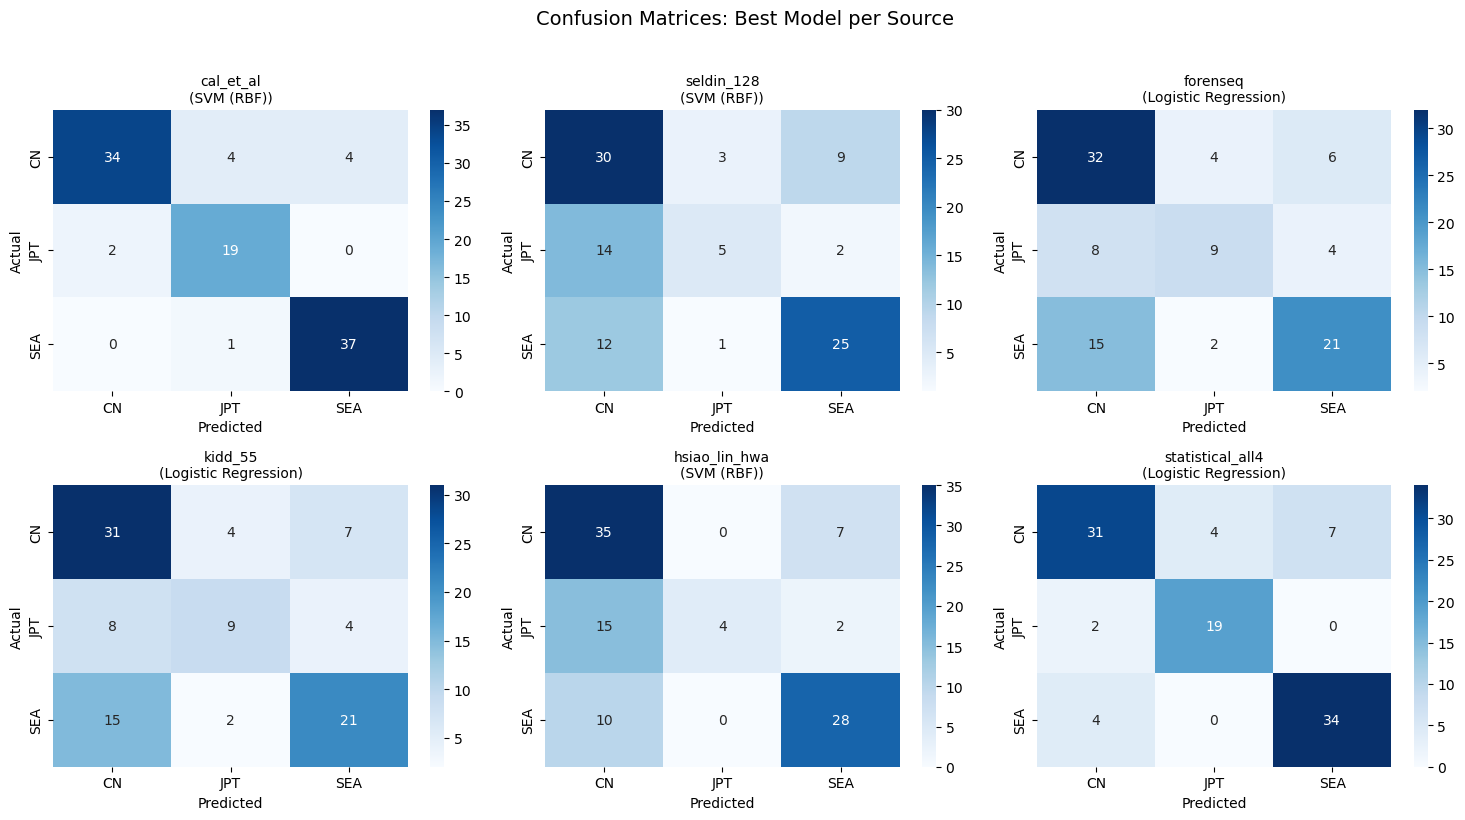

In [28]:
# Plot confusion matrices for all sources
n_sources = len(conf_matrices_all)
n_cols = min(3, n_sources)
n_rows = (n_sources + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_sources == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, (source_name, data) in enumerate(conf_matrices_all.items()):
    ax = axes[idx]
    sns.heatmap(data['cm'], annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=data['classes'], yticklabels=data['classes'])
    ax.set_title(f"{source_name}\n({data['model']})", fontsize=10)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Hide empty subplots
for idx in range(n_sources, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Confusion Matrices: Best Model per Source', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'confusion_matrices.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 7: Statistical Comparison

In [29]:
# Summary statistics per source
summary_stats = results_df.groupby('Source').agg({
    'N_SNPs': 'first',
    'Accuracy_Mean': ['mean', 'max', 'std'],
    'F1_Mean': ['mean', 'max'],
    'Overfit_Gap': 'mean'
}).round(4)

summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]

print("Summary Statistics by Source:")
print("="*80)
display(summary_stats)

Summary Statistics by Source:


,N_SNPs_first,Accuracy_Mean_mean,Accuracy_Mean_max,Accuracy_Mean_std,F1_Mean_mean,F1_Mean_max,Overfit_Gap_mean
Source,,,,,,,
cal_et_al,52,0.8866,0.9107,0.0262,0.8855,0.9107,0.0841
forenseq,55,0.6082,0.6726,0.0550,0.6006,0.6710,0.2524
hsiao_lin_hwa,125,0.5456,0.6269,0.0544,0.5282,0.6020,0.3661
kidd_55,53,0.6068,0.6726,0.0523,0.5983,0.6718,0.2502
seldin_128,124,0.5924,0.6488,0.0601,0.5752,0.6369,0.3524
statistical_all4,31,0.8089,0.8471,0.0506,0.8099,0.8477,0.0667


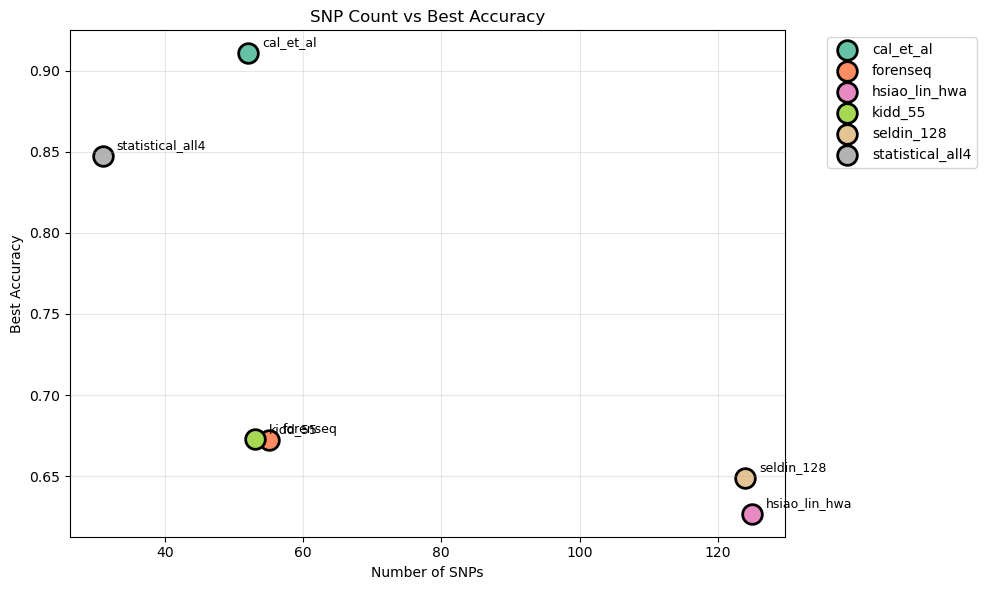

In [30]:
# SNPs vs Accuracy scatter
fig, ax = plt.subplots(figsize=(10, 6))

# Get best accuracy per source
best_per_source = results_df.loc[results_df.groupby('Source')['Accuracy_Mean'].idxmax()]

colors = plt.cm.Set2(np.linspace(0, 1, len(best_per_source)))

for i, (_, row) in enumerate(best_per_source.iterrows()):
    ax.scatter(row['N_SNPs'], row['Accuracy_Mean'], s=200, c=[colors[i]],
               edgecolors='black', linewidths=2, label=row['Source'])
    ax.annotate(row['Source'], (row['N_SNPs'], row['Accuracy_Mean']),
                xytext=(10, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Best Accuracy')
ax.set_title('SNP Count vs Best Accuracy')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(str(GRAPHS_DIR / 'snps_vs_accuracy.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 8: Save Results

In [31]:
# Save all results
PART2_DIR.mkdir(parents=True, exist_ok=True)

results_path = str(PART2_DIR / "ml_comparison_results.csv")
results_df.to_csv(results_path, index=False)
print(f"Results saved: {results_path}")

# Save pivot tables
pivot_accuracy.to_csv(str(PART2_DIR / "accuracy_by_source.csv"))
pivot_f1.to_csv(str(PART2_DIR / "f1_by_source.csv"))
print(f"Pivot tables saved")

# Create and save report
report_path = str(PART2_DIR / "ml_comparison_report.txt")
report = create_summary_report(results_df, report_path)

Results saved: /home/Plutonium/Documents/BioinfoMidterm/output/part2/sea_jpt_cn/ml_comparison_results.csv
Pivot tables saved
Report saved: /home/Plutonium/Documents/BioinfoMidterm/output/part2/sea_jpt_cn/ml_comparison_report.txt


## Summary

In [32]:
print("="*70)
print("KNOWN AISNPs ML COMPARISON SUMMARY")
print("="*70)

print(f"\nDatasets Compared: {len(datasets)}")
for name, df in datasets.items():
    n_snps = len([c for c in df.columns if c not in ['sample', 'pop', 'source']])
    print(f"  - {name}: {n_snps} SNPs")

print(f"\nClassifiers Tested: {len(classifiers)}")
print(f"Cross-Validation: {N_FOLDS}-Fold")

print(f"\nBest Performance per Source:")
for _, row in best_per_source.iterrows():
    print(f"  {row['Source']}: {row['Model']} ({row['Accuracy_Mean']:.4f} ± {row['Accuracy_Std']:.4f})")

# Overall best
overall_best = results_df.loc[results_df['Accuracy_Mean'].idxmax()]
print(f"\n★ Overall Best:")
print(f"  Source: {overall_best['Source']}")
print(f"  Model: {overall_best['Model']}")
print(f"  Accuracy: {overall_best['Accuracy_Mean']:.4f} ± {overall_best['Accuracy_Std']:.4f}")
print(f"  F1 Score: {overall_best['F1_Mean']:.4f}")

print(f"\nOutput Files:")
print(f"  - {PART2_DIR / 'ml_comparison_results.csv'}")
print(f"  - {PART2_DIR / 'ml_comparison_report.txt'}")
print(f"  - {GRAPHS_DIR / '*.png'} (plots)")

KNOWN AISNPs ML COMPARISON SUMMARY

Datasets Compared: 6
  - cal_et_al: 52 SNPs
  - seldin_128: 124 SNPs
  - forenseq: 55 SNPs
  - kidd_55: 53 SNPs
  - hsiao_lin_hwa: 125 SNPs
  - statistical_all4: 31 SNPs

Classifiers Tested: 7
Cross-Validation: 5-Fold

Best Performance per Source:
  cal_et_al: SVM (RBF) (0.9107 ± 0.0229)
  forenseq: Logistic Regression (0.6726 ± 0.0473)
  hsiao_lin_hwa: SVM (RBF) (0.6269 ± 0.0499)
  kidd_55: Logistic Regression (0.6726 ± 0.0541)
  seldin_128: SVM (RBF) (0.6488 ± 0.0432)
  statistical_all4: Logistic Regression (0.8471 ± 0.0431)

★ Overall Best:
  Source: cal_et_al
  Model: SVM (RBF)
  Accuracy: 0.9107 ± 0.0229
  F1 Score: 0.9107

Output Files:
  - /home/Plutonium/Documents/BioinfoMidterm/output/part2/sea_jpt_cn/ml_comparison_results.csv
  - /home/Plutonium/Documents/BioinfoMidterm/output/part2/sea_jpt_cn/ml_comparison_report.txt
  - /home/Plutonium/Documents/BioinfoMidterm/graphs/part2/sea_jpt_cn/*.png (plots)
